## Test logp

In [1]:
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az

import sys

sys.path.append("..")
from pymc_experimental.distributions.timeseries import DiscreteMarkovChain

In [2]:
with pm.Model() as model:
    logit_P = pm.Normal("logit_P", sigma=0.1, size=(3, 3))
    discrete_mc = DiscreteMarkovChain("MarkovChain", logit_P=logit_P, steps=10)

C:\Users\Jesse\Python Projects\pymc-experimental\notebooks\..\pymc_experimental\distributions\timeseries.py:153: UserWarning: Initial distribution not specified, defaulting to `Categorical.dist(p=pt.full((k_states, ), 1/k_states), shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(


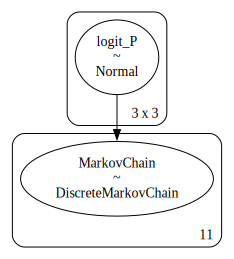

In [3]:
pm.model_to_graphviz(model)

In [4]:
pm.draw(discrete_mc, 10).shape

(10, 11)

## Recover transition matrix from data

In [7]:
from scipy import stats

true_P = np.array([[0.6, 0.2, 0.2], [0.5, 0.1, 0.4], [0.1, 0.1, 0.8]])

x0_dist = stats.bernoulli(0.5)


def generate_chains(P, x0_dist, steps, n_chains=1):
    output = np.empty((n_chains, steps), dtype="int64")

    x0 = x0_dist.rvs(n_chains)
    output[:, 0] = x0

    for t in range(1, steps):
        output[:, t] = [
            np.random.choice(range(P.shape[0]), p=P[output[i, t - 1]].ravel()).astype(int)
            for i in range(n_chains)
        ]

    return output.squeeze()

In [8]:
chains = generate_chains(true_P, x0_dist, 100, n_chains=100)

In [9]:
with pm.Model() as model:
    x0 = pm.Categorical.dist(np.ones(3) / 3, size=(100,))
    P = pm.Dirichlet("P", a=[1, 1, 1], size=(3,))
    discrete_mc = DiscreteMarkovChain("MarkovChain", P=P, init_dist=x0, observed=chains)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


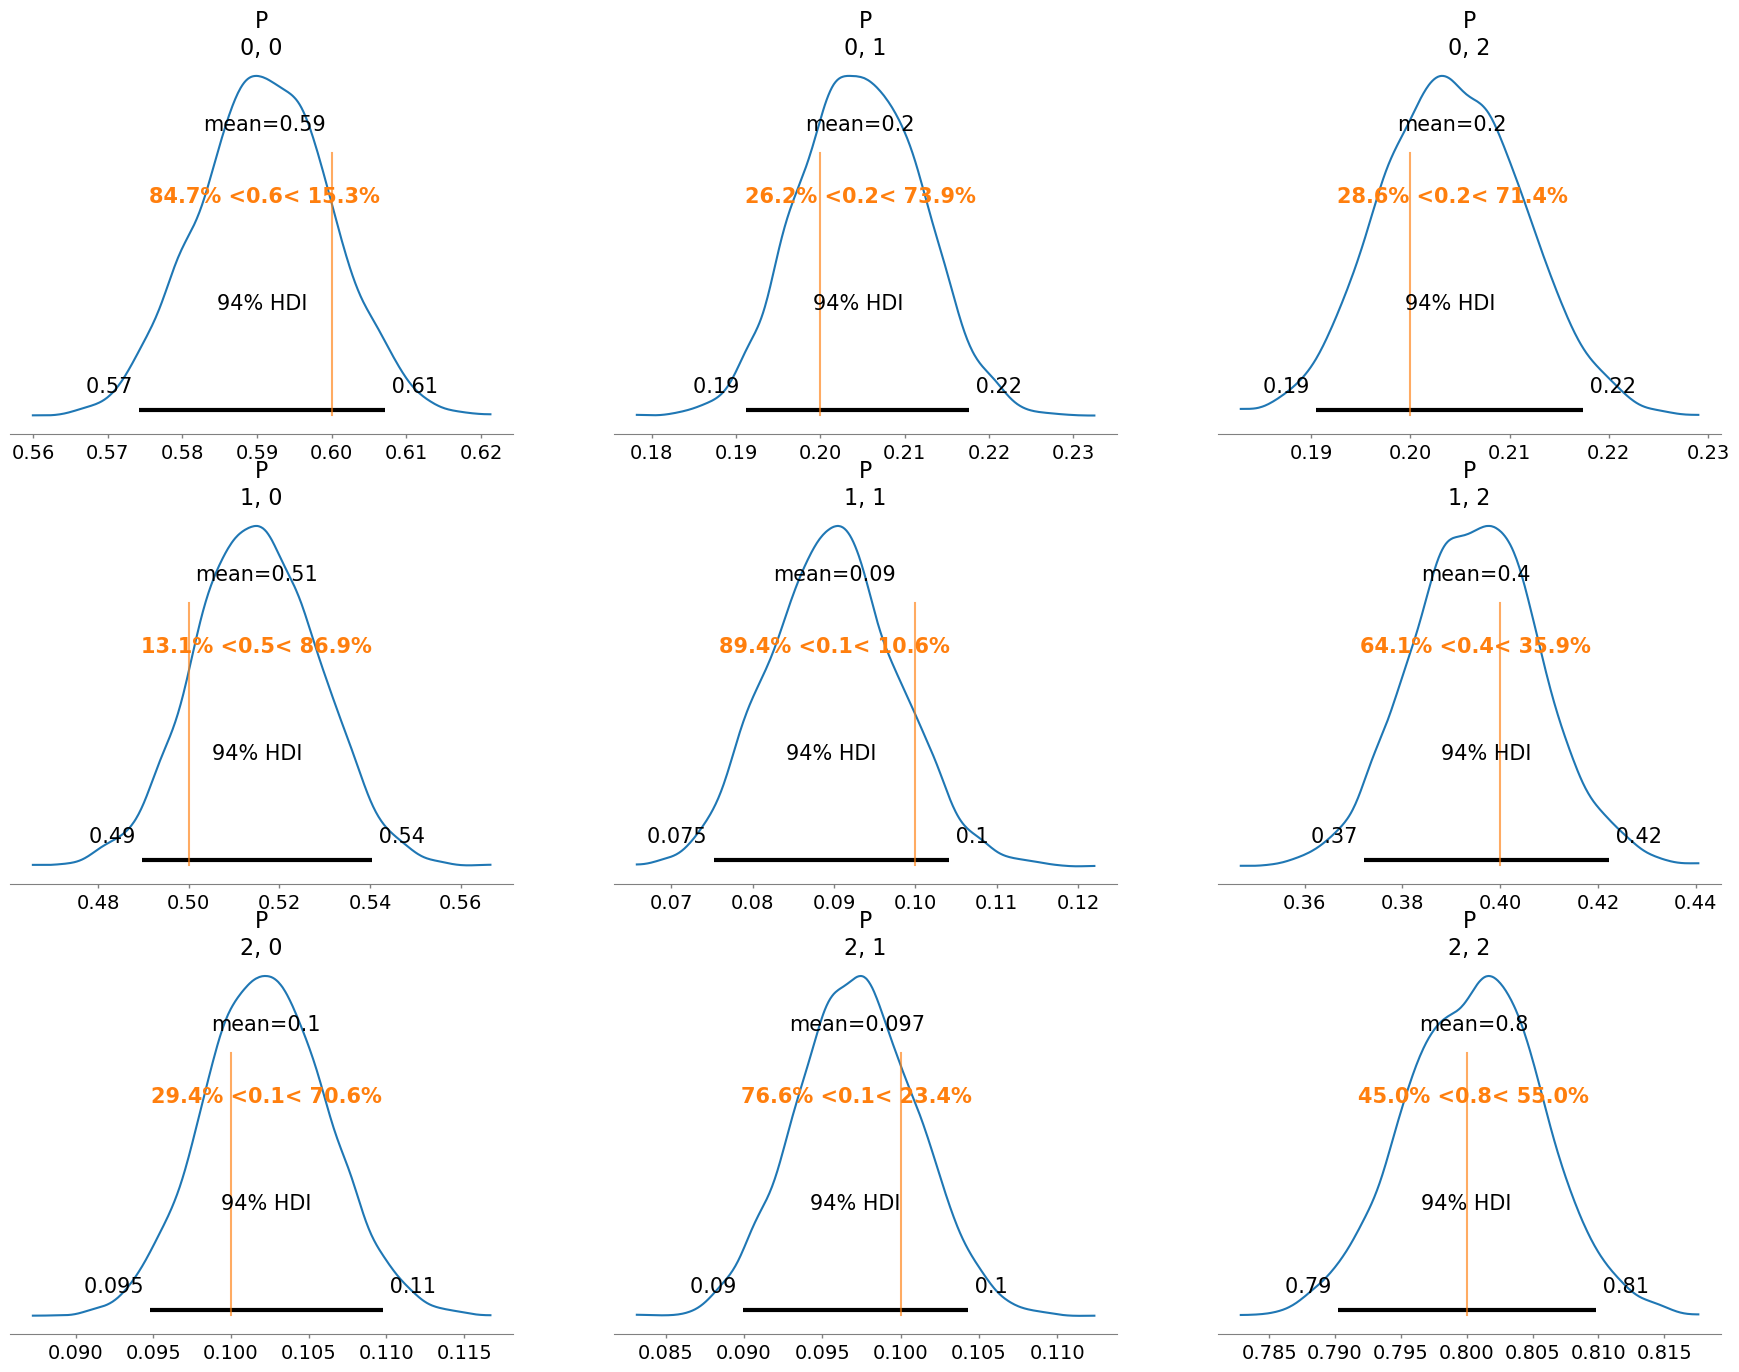

In [10]:
az.plot_posterior(idata, ref_val=true_P.ravel().tolist());

## Hidden markov model from statsmodels docs

https://www.statsmodels.org/dev/examples/notebooks/generated/markov_autoregression.html

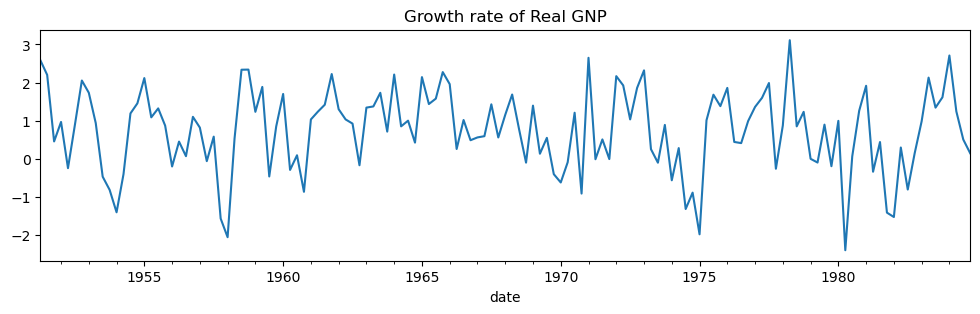

In [11]:
import pandas as pd
import statsmodels.api as sm

# Get the RGNP data to replicate Hamilton
dta = pd.read_stata("https://www.stata-press.com/data/r14/rgnp.dta").iloc[1:]
dta.index = pd.DatetimeIndex(dta.date, freq="QS")
dta_hamilton = dta.rgnp

# Plot the data
dta_hamilton.plot(title="Growth rate of Real GNP", figsize=(12, 3))

# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(dta_hamilton, k_regimes=2, order=4, switching_ar=False)
res_hamilton = mod_hamilton.fit()

In [12]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                     rgnp   No. Observations:                  131
Model:             MarkovAutoregression   Log Likelihood                -181.263
Date:                  Sat, 15 Apr 2023   AIC                            380.527
Time:                          16:55:26   BIC                            406.404
Sample:                      04-01-1951   HQIC                           391.042
                           - 10-01-1984                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1635      0.075     15.614      0.000       1.017       1.310
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5914      0.103      5.761      0.000       0.390       0.793
ar.L1          0.0135      0.120      0.112      0.911      -0.222       0.249
ar.L2         -0.0575      0.138     -0.418      0.676      -0.327       0.212
ar.L3         -0.2470      0.107     -2.310      0.021      -0.457      -0.037
ar.L4         -0.2129      0.111     -1.926      0.054      -0.430       0.004
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7547      0.097      7.819      0.000       0.565       0.944
p[1->0]        0.0959      0.038      2.542      0.011       0.022       0.170
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [13]:
T = dta_hamilton.shape[0]
order = 4

coords = {
    "dates": dta_hamilton.index,
    "obs_dates": dta_hamilton.index[order:],
    "states": ["State_1", "State_2"],
    "ar_params": [f"L{i+1}.phi" for i in range(order)],
}

with pm.Model(coords=coords) as hmm:
    y = pm.ConstantData("y", dta_hamilton, dims="dates")
    yobs = pm.ConstantData("yobs", dta_hamilton.iloc[4:], dims=["obs_dates"])

    s0 = pm.Bernoulli.dist(p=0.5)
    P = pm.Dirichlet("P", a=[1.0, 1.0], size=(2,))
    hidden_states = DiscreteMarkovChain(
        "hidden_states", P=P, init_dist=s0, steps=T - 1, dims=["dates"]
    )

    state_mus = pm.Normal(
        "state_mus",
        dims=["states"],
        transform=pm.distributions.transforms.univariate_ordered,
        initval=[-1, 1],
    )
    ar_coefs = pm.Normal("coefs", size=order, dims=["ar_params"])

    def AR_step(s, L1_s, L2_s, L3_s, L4_s, L1_y, L2_y, L3_y, L4_y, mus, phis):

        y_out = (
            mus[s]
            + phis[0] * (L1_y - mus[L1_s])
            + phis[1] * (L2_y - mus[L2_s])
            + phis[2] * (L3_y - mus[L3_s])
            + phis[3] * (L4_y - mus[L4_s])
        )

        return y_out

    result, updates = pytensor.scan(
        AR_step,
        sequences=[
            {"input": hidden_states, "taps": [0, -1, -2, -3, -4]},
            {"input": y, "taps": [-1, -2, -3, -4]},
        ],
        non_sequences=[state_mus, ar_coefs],
    )

    sigma = pm.HalfCauchy("sigma", 0.8)
    obs = pm.Normal("y_hat", mu=result, sigma=sigma, observed=yobs, dims=["obs_dates"])

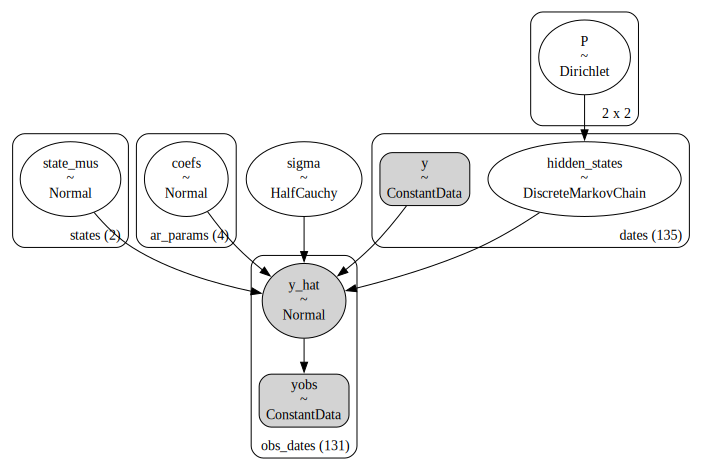

In [14]:
pm.model_to_graphviz(hmm)

In [17]:
with hmm:
    # Need to assign BinaryMetropolis by hand, defaults to Metropolis and breaks.
    # BinaryGibbsMetropois seems to do much beter than BinaryMetropolis, but also much slower.
    idata = pm.sample(
        step=[
            pm.BinaryGibbsMetropolis([hidden_states]),
            pm.NUTS([P, state_mus, ar_coefs, sigma], target_accept=0.99),
        ],
        draws=5_000,
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [hidden_states]
>NUTS: [P, state_mus, coefs, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2024 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<Axes: >

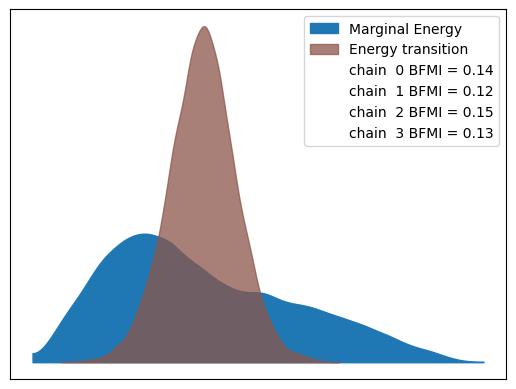

In [18]:
az.plot_energy(idata)

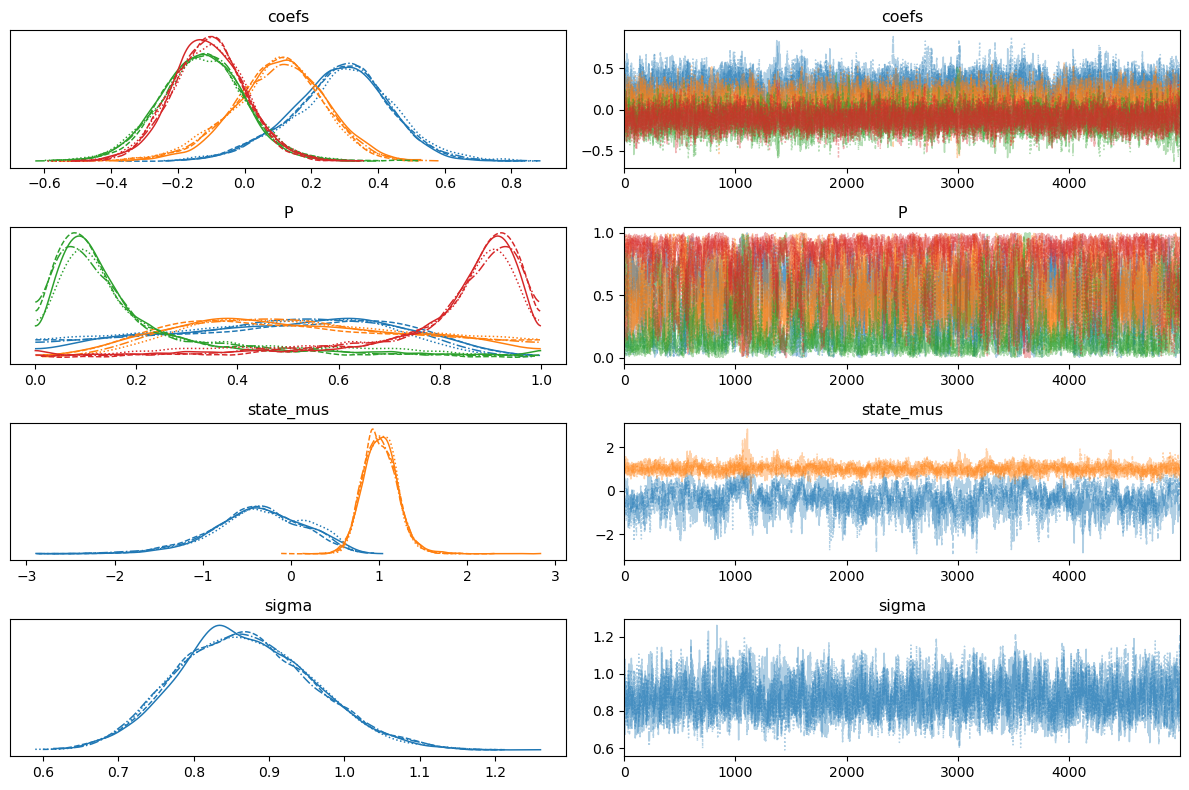

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

az.plot_trace(idata, var_names=["~hidden_states"])
plt.tight_layout();

In [20]:
az.summary(idata, var_names=["~hidden_states"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[L1.phi],0.288,0.152,-0.013,0.563,0.006,0.004,742.0,1615.0,1.01
coefs[L2.phi],0.098,0.139,-0.158,0.365,0.004,0.002,1657.0,1919.0,1.00
coefs[L3.phi],-0.126,0.129,-0.364,0.121,0.003,0.002,1956.0,3385.0,1.00
coefs[L4.phi],-0.107,0.112,-0.315,0.105,0.002,0.002,2621.0,4505.0,1.00
"P[0, 0]",0.468,0.227,0.041,0.830,0.009,0.007,585.0,1160.0,1.01
"P[0, 1]",0.532,0.227,0.170,0.959,0.009,0.007,585.0,1160.0,1.01
"P[1, 0]",0.200,0.196,0.000,0.622,0.014,0.010,255.0,322.0,1.03
"P[1, 1]",0.800,0.196,0.378,1.000,0.014,0.010,255.0,322.0,1.03
state_mus[State_1],-0.372,0.527,-1.328,0.597,0.030,0.021,300.0,562.0,1.01
state_mus[State_2],1.011,0.193,0.652,1.351,0.008,0.006,611.0,1548.0,1.01


In [21]:
with hmm:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [y_hat]


In [22]:
post_pred = az.extract(idata, "posterior_predictive").y_hat
post = az.extract(idata)

mu = post_pred.mean("sample")
ci05, ci95 = post_pred.quantile([0.05, 0.95], dim="sample")

In [23]:
sm_preds = res_hamilton.predict()

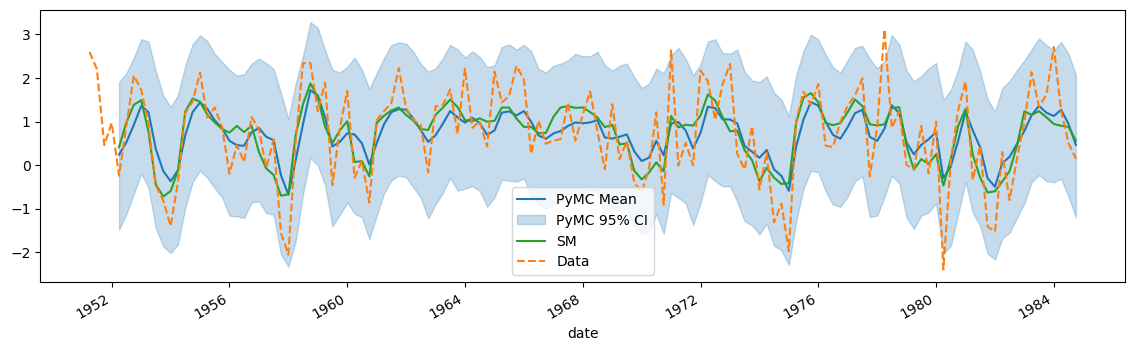

In [24]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(mu.coords["obs_dates"], mu, label="PyMC Mean")
ax.fill_between(
    mu.coords["obs_dates"], ci05, ci95, alpha=0.25, color="tab:blue", label="PyMC 95% CI"
)

ax.plot(sm_preds, color="tab:green", label="SM")
dta_hamilton.plot(ax=ax, ls="--", color="tab:orange", label="Data")

ax.legend()
plt.show()

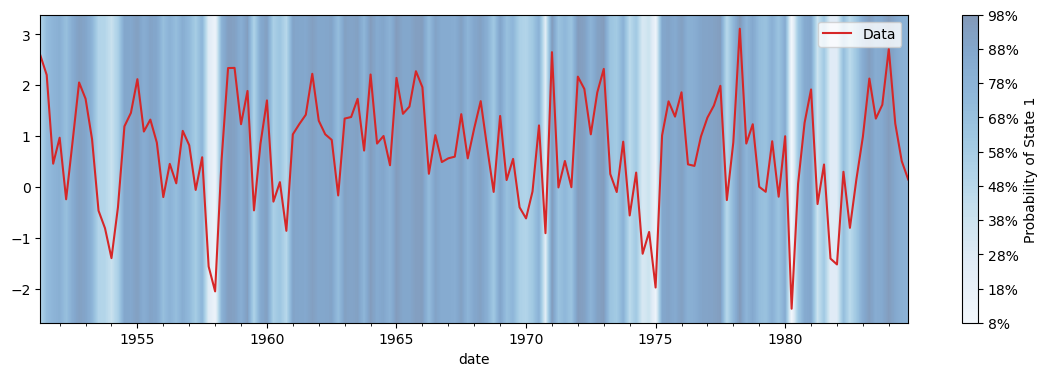

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker as mtick

fig, ax = plt.subplots(figsize=(14, 4))
dta_hamilton.plot(ax=ax, color="tab:red", label="Data")

p_state_1 = post.hidden_states.mean(dim=["sample"])
ymin, ymax = ax.get_ylim()
y = np.linspace(ymin, ymax, T)
z, _ = np.meshgrid(p_state_1, p_state_1)

num_bars = 100
contour_plot = ax.contourf(dta_hamilton.index, y, z, num_bars, cmap="Blues", alpha=0.5, zorder=0)
contour_plot.set_clim(vmin=0, vmax=1)

cbar = fig.colorbar(
    contour_plot, ax=ax, label="Probability of State 1", format=mtick.PercentFormatter(xmax=1)
)

ax.legend()
plt.show()